# Try This Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.mixture import GaussianMixture

In this exercise, you will compare the performance of `k-means` and `Gaussian Mixture Model` for the simulated 2-dimensional data in `gmm_kmeans_test_data.dat`.  

 1. Read in the data and plot.
 2. Perform a k-means cluster analysis on the data.  
    - You may assume there are four clusters present. 
    - Plot the resulting cluster assignments, along with the cluster centers.
    - Verify (or check) whether four clusters is the optimal number of clusters (based on a variance plot.
 3. Perform a gaussian mixture model analysis on the data set.  
    - You may again assume there are four clusters present.
    - Plot the resulting cluster assignments along with the cluster centers.
    - Verify (or check) whether four clusters is the optimal number of clusters.
 4. Which cluster method do you think performs better for these data? 

### Answer:

I wasn't sure if I should scale the data based on the last try-this... but if not, you can just uncomment the 3 lines that scale the data. I kept the scaling for both the $K$-means and the GMM clustering.

In [2]:
fn = '../../lectures/lecture12/gmm_kmeans_test_data.dat'
data = np.loadtxt(fn)

# scale data
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data = (data - mean) / std

Below I've performed a $K$-means clustering of this 2D set of data, and I've plotted the data in corresponding group colors as well as their centroids as black "X" markers.

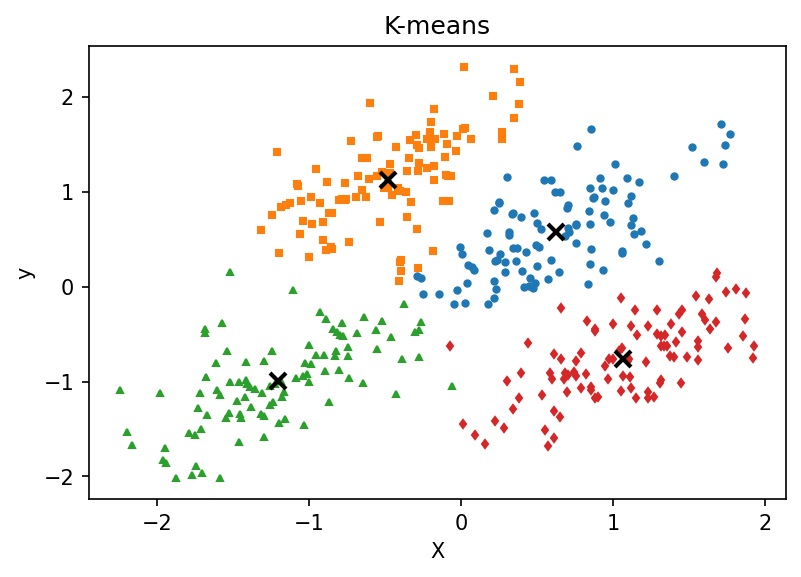

In [3]:
n_components = 4
markers = ('o', 's', '^', 'd')
colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

# k means
centroids, _ = kmeans(data, n_components)
ids, _ = vq(data, centroids)

fig, ax = plt.subplots(dpi=150)

for i in range(n_components):
    mask = ids == i
    ax.plot(data[mask][:, 0], data[mask][:, 1], markers[i], ms=3, c=colors[i], zorder=0)
    ax.plot(centroids[i][0], centroids[i][1], 'x', mew=2, ms=8, c='k', zorder=1)

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('K-means')
    
plt.show()

Below, using $K$-means we see that four clusters is a reasonable optimal number of groups for this 2D set of data.

In [4]:
n_dim = data.shape[1]

def centroid_var(data, centroid):
    sumterms = (data - centroid)**2
    N = len(data)
    var = np.sum(sumterms, axis=0)
    return var.sum()

def total_variance(data, n_components):
    centroids, _ = kmeans(data, n_components)
    ids, _ = vq(data, centroids)
    variances = np.array([centroid_var(data[ids==i], centroids[i])
                          for i in range(n_components)])
    return variances.sum()

global_var = centroid_var(data, np.mean(data, axis=0))

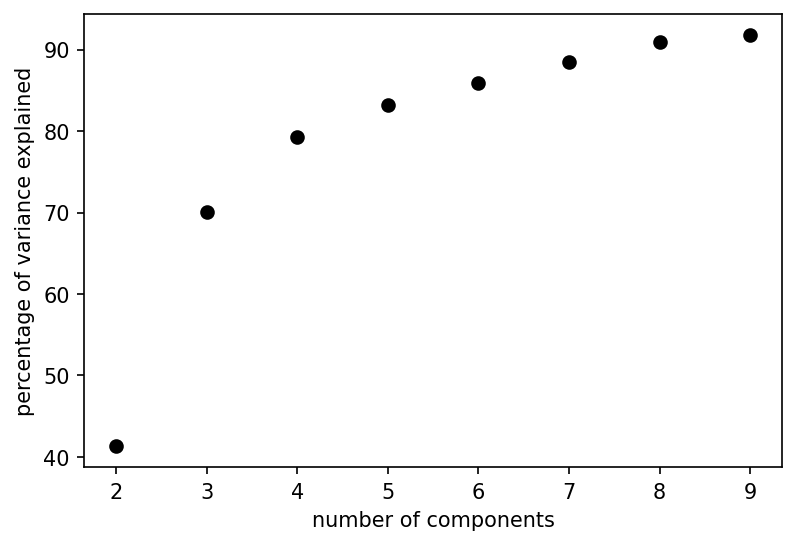

In [5]:
K_range = np.arange(2, 10)
total_var = np.array([total_variance(data, n) for n in K_range])
p_diff = (global_var - total_var) * 100 / global_var

fig, ax = plt.subplots(dpi=150)

ax.plot(K_range, p_diff, 'ko')

ax.set_xlabel('number of components')
ax.set_ylabel('percentage of variance explained')

plt.show()

Below I perform a GMM analysis on the same (scaled) data set. Most probable group assignments are given in different colors/symbols, and the covariance is illustrated in the form of contours representing 1-, 2-, and 3$\sigma$ from each mean.

In [6]:
# I stole some (condensed and tbh not super optimized) code
# from myself from a recent project... It's not exactly Jupyter
# friendly and I can't import it using another file since I
# don't think I can submit multiple files
from itertools import product


class MultiGauss:

    def __init__(self, mu, cov):
        self.m = len(mu)
        self.mu = np.asarray(mu)
        self.cov = np.asarray(cov)

        self._cov_inv = None
        self._cov_det = None
        self._norm = None

    @property
    def cov_inv(self):
        if self._cov_inv is None:
            self._cov_inv = np.linalg.inv(self.cov)

        return self._cov_inv

    @property
    def cov_det(self):
        if self._cov_det is None:
            self._cov_det = np.linalg.det(self.cov)

        return self._cov_det
    
    @property
    def norm(self):
        if self._norm is None:
            self._norm = np.sqrt(self.cov_det * (2 * np.pi)**self.m)
            
        return self._norm
        
    def span_pdf(self, X1, X2, normalize=True, ravel=False):
        '''Calculate the Gaussian PDF for the Cartesian product of two given sets.'''
        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
    
        n = len(X1)
        g = np.zeros((n, n))

        # yes this makes a giant ass NxN copy, it needs work
        X = np.array(list(product(X1, X2)))
        g = self.pdf(X, normalize=normalize)

        g = g.reshape(n, n).T
        
        if ravel:
            return g.ravel()

        return g

    def pdf(self, X, normalize=True):
        '''Calculate the Gaussian PDF at given points.'''
        X = np.asarray(X)
        
        if len(X.shape) == 1:
            return self._gauss_single(X, normalize=normalize)

        return self._gauss_multiple(X, normalize=normalize)

    def _gauss_single(self, X, normalize):
        '''Calculate multivariate Gaussian PDF at a single point.'''
        x_mu = X - self.mu

        arg = x_mu @ self.cov_inv @ x_mu
        g = np.exp(-0.5 * arg)

        if normalize:
            g /= self.norm

        return g
    
    def _gauss_multiple(self, X, normalize):
        '''Calculate multivariate Gaussian PDF at multiple points.'''
        x_mu = X - self.mu

        arg = x_mu * (self.cov_inv @ x_mu.T).T
        arg = arg.sum(axis=1)
        g = np.exp(-0.5 * arg)

        if normalize:
            g /= self.norm

        return g


con_colors = ['#bdbdbd', '#595959', '#1f1f1f', 'k']


def draw_contours(axis, gmm, xbounds, ybounds, con_density=400, alpha=0.7):
    """Draw 2D (filled) contours on axis with 1-, 2-, 3-sigma levels"""
    con0 = np.linspace(*xbounds, con_density)
    con1 = np.linspace(*ybounds, con_density)

    for i in range(gmm.n_components):
        mu = gmm.means_[i]
        cov = gmm.covariances_[i]
        gauss = MultiGauss(mu, cov)

        z_con = gauss.span_pdf(con0, con1)

        sig = 1 / np.sqrt(gauss.cov_inv[0, 0])
        sig_point = mu.copy()
        z_levels = []
        for level in range(3):
            sig_point[0] += sig
            z_level = gauss.pdf(sig_point)
            z_levels.append(z_level)

        z_levels = list(reversed(z_levels))
        z_levels.append(1.1)

        for j in range(3):
            axis.contourf(con0, con1, z_con, levels=[z_levels[j], 1.5],
                          colors=[con_colors[j], 'k'], alpha=alpha,
                          antialiased=True, zorder=j - 3)

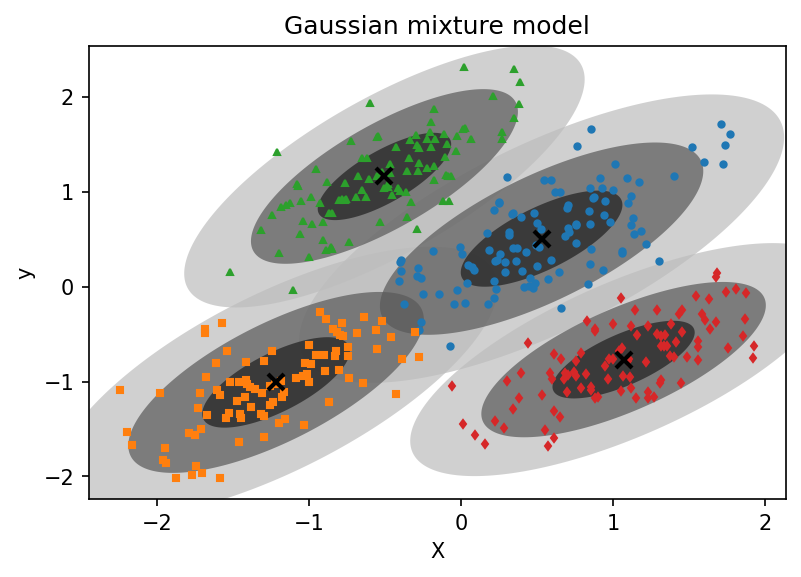

In [7]:
# GMM
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)
ids = gmm.predict(data)

fig, ax = plt.subplots(dpi=150)

for i in range(n_components):
    mask = ids == i
    X = data[mask][:, 0]
    y = data[mask][:, 1]
    ax.plot(X, y, markers[i], ms=3, c=colors[i], zorder=0)
    ax.plot(gmm.means_[i][0], gmm.means_[i][1], 'x', mew=2, ms=8, c='k', zorder=1)
    
# contours
draw_contours(ax, gmm, ax.get_xlim(), ax.get_ylim())

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Gaussian mixture model')

plt.show()

Here I calculate the AIC and BIC metrics for $2 \geq K \geq 9$ based on 20 trial runs (so that the mean is plotted with the standard deviation of the set of BIC/AIC values calculated being the errors). It is clear from this that $K=4$ Gaussian components best represent the data.

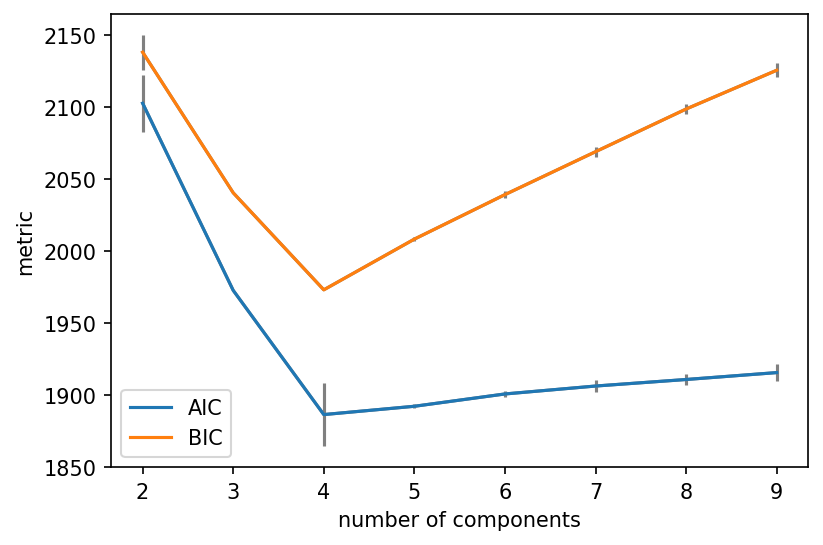

In [8]:
n_runs = 20

def bic(data, n_components):
    _bic = []
    for i in range(n_runs):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data)
        _bic.append(gmm.bic(data))
    _bic = np.array(_bic)
    return _bic.mean(), _bic.std()

def aic(data, n_components):
    _aic = []
    for i in range(n_runs):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data)
        _aic.append(gmm.aic(data))
    _aic = np.array(_aic)
    return _aic.mean(), _aic.std()

bic_vals = np.array([bic(data, n) for n in K_range])
aic_vals = np.array([aic(data, n) for n in K_range])

fig, ax = plt.subplots(dpi=150)

ax.plot(K_range, aic_vals[:, 0], c='tab:blue', label='AIC', zorder=1)
ax.plot(K_range, bic_vals[:, 0], c='tab:orange', label='BIC', zorder=1)
ax.errorbar(K_range, aic_vals[:, 0], yerr=aic_vals[:, 1], color='grey', zorder=0)
ax.errorbar(K_range, bic_vals[:, 0], yerr=bic_vals[:, 1], color='grey', zorder=0)

ax.set_xlabel('number of components')
ax.set_ylabel('metric')

ax.legend()

plt.show()

Just through visual inspection, I would say that the GMM represents the data and performs better, as all the group assignments seem more natural compared to the $K$-means clustering. It is difficult to get a good $K$-means result with the underlying clusters are so close together, as the edge points often become skewed to a different group than one might expect. One might calculate something such as a Silhouette score (using the most likely group assignments for the GMM) to provide a more quantifiable reasoning as to which performs better.